In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join, exists
from sklearn.mixture import BayesianGaussianMixture
from impyute.imputation.cs import mice, fast_knn

In [2]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [3]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data.csv"), index_col=0, header=0)
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [5]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [11]:
# subset by atlas for smri and rsfmri (variance) data
smri_atlas = {'cdk': [], 
              'mrisdp': [],
              'cf12': []}
rsfmri_atlas = {'cdk': [],
                'cortgordon': []}

for atlas in smri_atlas.keys():
    smri_atlas[atlas] = list(deltasmri_complete.filter(regex=f'{atlas}.*').columns)

for atlas in rsfmri_atlas.keys():
    rsfmri_atlas[atlas] = list(deltarsfmri_complete.filter(regex=f'{atlas}.*').columns)

In [15]:
# build data subsets for clustering
cdk_columns = smri_atlas['cdk'] + rsfmri_atlas['cdk'] + list(deltarsi_complete.columns) + list(deltadti_complete.columns)
cdk_data = df.filter(cdk_columns)

In [24]:
# let's impute some missing values, heyyyyy
imputed_cdk = pd.DataFrame(data=fast_knn(cdk_data.values), 
                           columns=cdk_data.columns, index=cdk_data.index)

In [25]:
imputed_cdk.describe()

,smri_vol_cdk_total.change_score,smri_area_cdk_banksstslh.change_score,smri_area_cdk_cdacatelh.change_score,smri_area_cdk_cdmdfrlh.change_score,smri_area_cdk_cuneuslh.change_score,smri_area_cdk_ehinallh.change_score,smri_area_cdk_fusiformlh.change_score,smri_area_cdk_ifpllh.change_score,smri_area_cdk_iftmlh.change_score,smri_area_cdk_ihcatelh.change_score,...,dmri_dtivol_fiberat_fscsrh.change_score,dmri_dtivol_fiberat_fscslh.change_score,dmri_dtivol_fiberat_pscsrh.change_score,dmri_dtivol_fiberat_pscslh.change_score,dmri_dtivol_fiberat_sifcrh.change_score,dmri_dtivol_fiberat_sifclh.change_score,dmri_dtivol_fiberat_ifsfcrh.change_score,dmri_dtivol_fiberat_ifsfclh.change_score,dmri_dtivol_fiberat_fxcutrh.change_score,dmri_dtivol_fiberat_fxcutlh.change_score
count,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,...,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000,7802.000000
mean,-0.918703,-0.340286,0.726884,0.181491,0.017468,0.555755,0.199364,-0.493266,0.292936,-0.137105,...,1.711219,1.672986,2.157856,2.088607,1.818061,1.959271,1.892023,1.925927,1.528784,2.075226
std,1.145465,2.859331,2.675971,2.824850,1.851899,5.473851,1.506527,1.995164,1.883279,2.214238,...,2.048734,2.205640,2.349231,2.457102,3.102134,2.976549,2.058309,2.477715,3.811961,3.883389
min,-15.801404,-28.871111,-28.767677,-29.224690,-33.902110,-34.011429,-22.973925,-19.592383,-23.268651,-49.000962,...,-59.549795,-57.375586,-67.461263,-61.293390,-33.869263,-38.037736,-37.055838,-44.303797,-87.169811,-82.352941
25%,-1.431812,-1.649631,-0.731940,-0.700735,-0.891214,-2.472655,-0.569409,-1.143516,-0.507647,-1.304334,...,0.787148,0.656089,1.177584,1.055015,0.447781,0.653723,0.967834,0.882518,0.000000,0.450959
50%,-0.852066,-0.307536,0.726884,0.235203,0.030741,0.555755,0.211334,-0.382302,0.325932,-0.137105,...,1.714039,1.618452,2.160465,2.028595,1.583336,1.814526,1.838766,1.853674,1.530498,2.081812
75%,-0.312414,1.060475,2.193853,1.149336,1.013522,3.581076,0.990187,0.297042,1.134262,1.014589,...,2.568151,2.474848,3.038693,2.939601,2.710406,2.908698,2.636422,2.788096,2.988792,3.488718
max,7.788832,19.887159,21.735221,26.461783,29.078628,42.996639,20.183486,18.090274,15.528707,28.605241,...,35.313623,74.589928,47.546123,69.810298,40.180490,72.000000,31.723454,89.545595,53.246753,72.413793


In [ ]:
imputed_cdk.to_csv(join(join(PROJ_DIR, DATA_DIR, "desikankillany_KNNimputed_data.csv")))

In [72]:
bgmm = BayesianGaussianMixture(n_components=5, 
                               weight_concentration_prior_type='dirichlet_process',
                               weight_concentration_prior=10)

In [73]:
labels = bgmm.fit_predict(imputed_cdk)

In [74]:
np.unique(labels)

array([0, 1, 2, 3, 4])

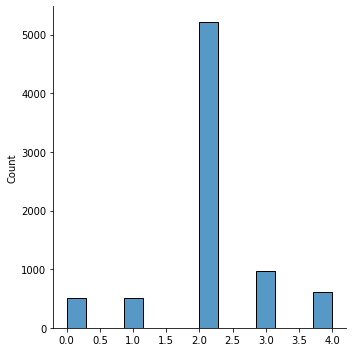

In [75]:
import seaborn as sns
sns.displot(labels)

In [33]:
clustered_ndars = pd.Series(labels, index=imputed_cdk.index)